## Installing packages

In [ ]:
 !pip install scanpy
 !pip install decoupler
 !pip install leidenalg
 !pip install omnipath
 !pip install anndata
 !pip install scikit-learn

## Downloading data

In [ ]:
!wget -O GTEX-1HSMQ-5005.h5ad  "https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680"

## Analyzing data

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
from sklearn.metrics import davies_bouldin_score

In [2]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata.shape

(14404, 17695)

In [3]:
def dbi_index_calc_print(_adata):
    print("dbi score")
    inData = _adata.obsm["X_umap"]
    #print(inData.shape)
    labels = _adata.obs["leiden"]
    score = davies_bouldin_score(inData, labels)
    print("DaviesBouldin Score: " + str(score))
    return score

### With normalization

In [17]:
ada = adata[adata.obs.batch == '49'].copy()#


In [18]:
sc.pp.filter_cells(ada, min_genes=200)
sc.pp.filter_genes(ada, min_cells=3)

ada.var['mt'] = ada.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ada, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(ada, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
#sc.pl.scatter(ada, x="total_counts", y="pct_counts_mt")
#sc.pl.scatter(ada, x="total_counts", y="n_genes_by_counts")
ada = ada[ada.obs.n_genes_by_counts < 2000, :]


Normalizing...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


PCA...
UMAP...
leden
dbi score
DaviesBouldin Score: 0.6284331673542591


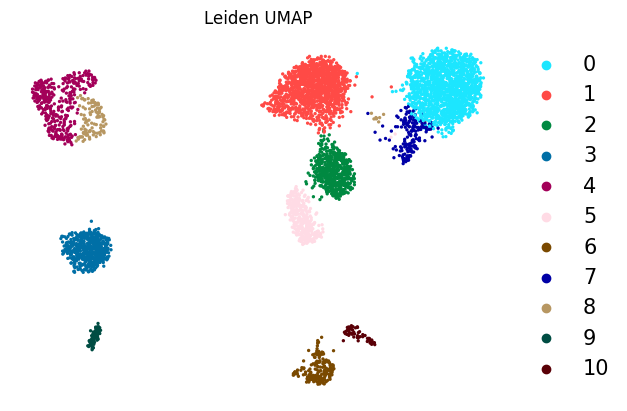

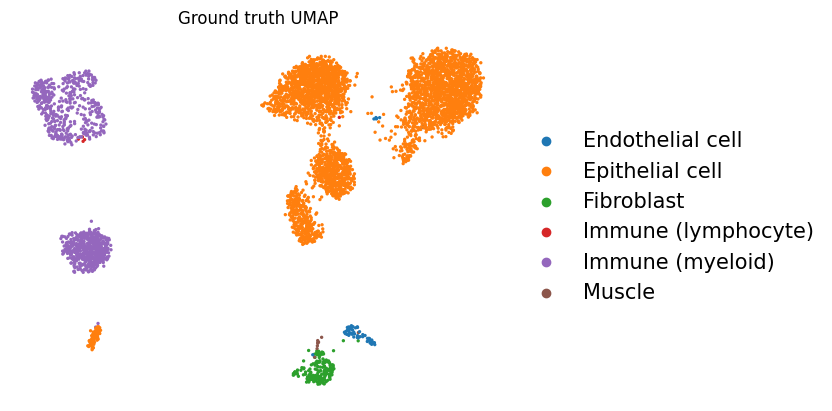

In [19]:


# Normalize the data
print("Normalizing...")
sc.pp.normalize_total(ada, target_sum=1e4)
sc.pp.log1p(ada)
ada.layers['log_norm'] = ada.X.copy()


# Identify the highly variable genes
sc.pp.highly_variable_genes(ada, min_mean=0.0125, max_mean=3, min_disp=0.5)

#print("RegressOut...")
# Regress and scale the data
#sc.pp.regress_out(ada, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(ada, max_value=10)

print("PCA...")
# Generate PCA features
sc.tl.pca(ada, svd_solver='arpack')

#Restore X to be norm counts
dc.swap_layer(ada, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada, n_neighbors=10, n_pcs=40)

print("UMAP...")
# Generate UMAP features
sc.tl.umap(ada)


print("leden")
# Run leiden clustering algorithm
sc.tl.leiden(ada)
score1normalized = dbi_index_calc_print(ada)

# Visualize
sc.pl.umap(ada, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)




dbi score
DaviesBouldin Score: 0.4609110366145233


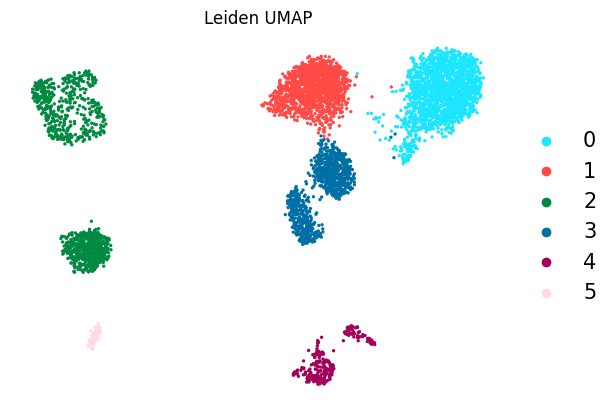

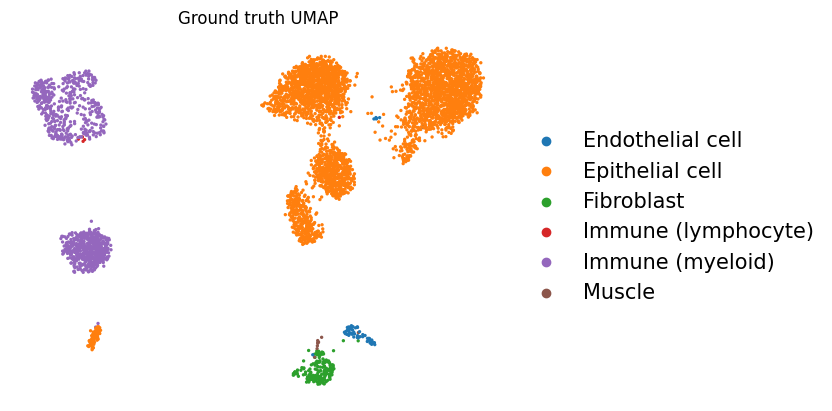

In [20]:
sc.tl.leiden(ada, resolution=0.05)
score2normalized = dbi_index_calc_print(ada)
# Visualize
sc.pl.umap(ada, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

### Without normalization

In [27]:
ada2 = adata[adata.obs.batch == '49'].copy()#

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


leden
dbi score
DaviesBouldin Score: 0.6608243552075496


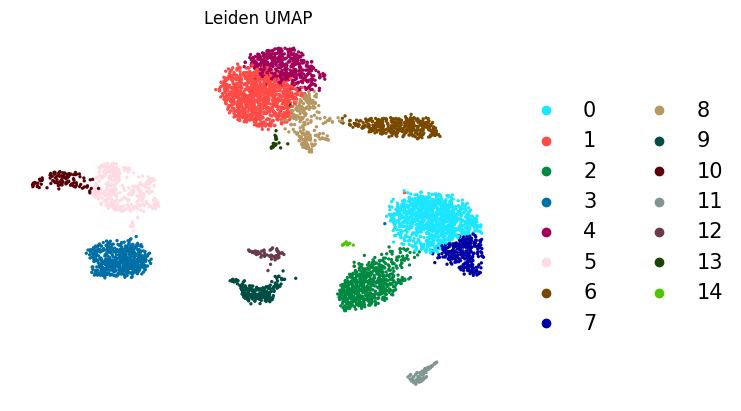

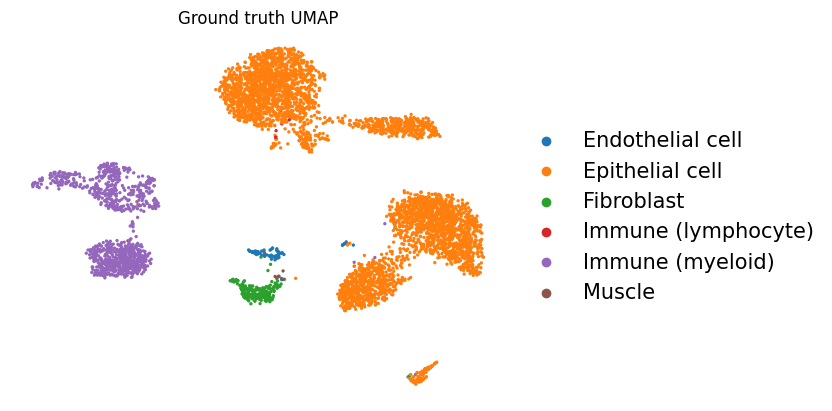

In [28]:
sc.pp.filter_cells(ada2, min_genes=200)
sc.pp.filter_genes(ada2, min_cells=3)
ada2.var['mt'] = ada2.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ada2, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
ada2 = ada2[ada2.obs.n_genes_by_counts < 2000, :]

# Normalize the data
#sc.pp.normalize_total(ada2, target_sum=1e4)
#sc.pp.log1p(ada2)

sc.pp.highly_variable_genes(ada2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(ada2, max_value=10)

# Generate PCA features
sc.tl.pca(ada2, svd_solver='arpack')
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada2, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(ada2)

print("leden")
# Run leiden clustering algorithm
sc.tl.leiden(ada2)
score1notNormalized = dbi_index_calc_print(ada2)

# Visualize
sc.pl.umap(ada2, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada2, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

dbi score
DaviesBouldin Score: 0.47818429429902515


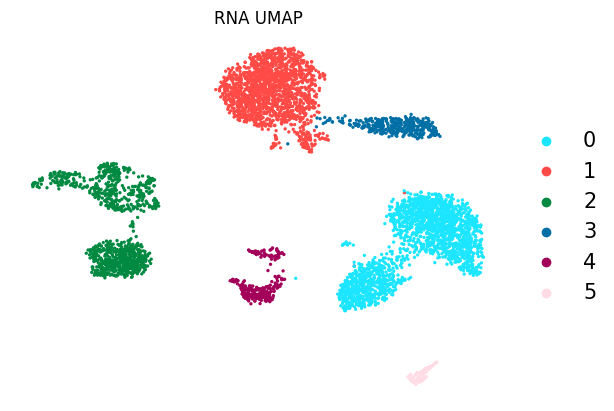

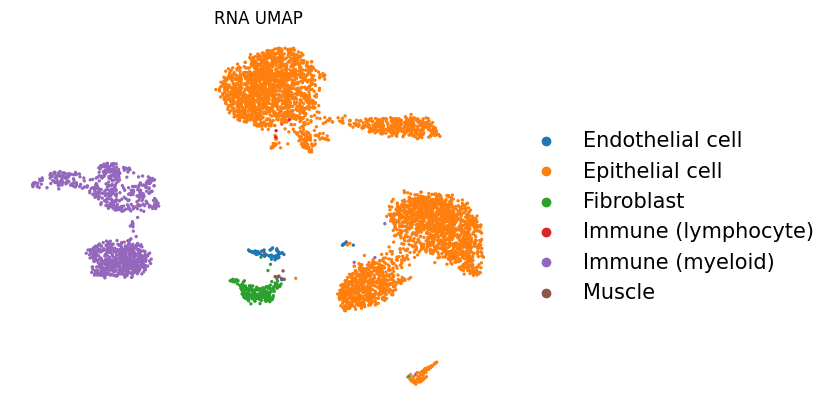

In [29]:
# Run leiden clustering algorithm
sc.tl.leiden(ada2, resolution=0.05)
score2notNormalized = dbi_index_calc_print(ada2)
# Visualize
sc.pl.umap(ada2, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
# Visualize
sc.pl.umap(ada2, color='Cell types level 2', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

##Results

We have gotten better results by using normalization.

In [26]:
print("Results - with Normalization")
print(score1normalized)
print(score2normalized)
print("----------------------------------")
print("Results - without normalization")
print(score1notNormalized)
print(score2notNormalized)

Results - with Normalization
0.6284331673542591
0.4609110366145233
----------------------------------
Results - without normalization
0.6608243552075496
0.47818429429902515
